In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import os

In [38]:
#read in all predicted values as well as the rows that had missing values
tiles = pd.read_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/all_predictions_linear.pkl')
missing = pd.read_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/missing_tiles.pkl')

all_tiles = pd.concat([tiles, missing], ignore_index=False)
del tiles, missing

non_null_tiles = all_tiles.dropna()

In [39]:
#save all_tiles and non_null_tiles both as tab seperated files without column headings. Not sure which one will
#work better for SHARPR so saving both

all_tiles.to_csv('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/all_tiles.tsv',
                 sep = '\t', header = False, index = True)
non_null_tiles.to_csv('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/non_null_tiles.tsv',
                 sep = '\t', header = False, index = True)

non_null_tiles = '/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/non_null_tiles.tsv'
all_tiles = '/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/all_tiles.tsv'

In [40]:
########## Tev's Code ############

# you need to download and extract the SHARPR package for this to work
# https://ernstlab.biolchem.ucla.edu/SHARPR/SHARPR.zip
# read the manual if something doesn't work

def compute_sharpr_from_tiles(tile_fn, varprior_1=1, varprior_2=None):
    """ Computes SHARPR scores from tile matrix.

        Format of tile_fn is the same as SHARPR tile matrix format, tab-separated,
        rows are regions and columns are tiles. 
    """
    tilelength = 145
    stepsize = 5
    numtilepos = 31

    if varprior_2 is None:
        varprior_2 = varprior_1
    
    with tempfile.TemporaryDirectory() as tmpdir:
        inputtablefile = tile_fn
        inferenceoutputfile_1 = f'{tmpdir}/inference_out.varprior_{varprior_1}.tsv'
        
        cmd_ = f"java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Infer {inputtablefile} {inferenceoutputfile_1} {varprior_1} {tilelength} {stepsize} {numtilepos}"
        os.system(cmd_)
        print(cmd_)
        
        inferenceoutputfile_2 = f'{tmpdir}/inference_out.varprior_{varprior_2}.tsv'
        
        cmd_ = f"java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Infer {inputtablefile} {inferenceoutputfile_2} {varprior_2} {tilelength} {stepsize} {numtilepos}"
        os.system(cmd_)
        print(cmd_)
        
        fileset1 = f"{inferenceoutputfile_1}"
        fileset2 = f"{inferenceoutputfile_2}"
        
        combineoutputfile = f'{tmpdir}/combineoutput.tsv'
        
        cmd_ = f"java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Combine -c {fileset2} {fileset1} {combineoutputfile}"
        os.system(cmd_)
        print(cmd_)
        
        interpolateinputfile = combineoutputfile
        interpolateoutputfile = f'{tmpdir}/interpolate_out.tsv'
        
        cmd_ = f"java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Interpolate {interpolateinputfile} {interpolateoutputfile} {stepsize}"
        os.system(cmd_)
        print(cmd_)
        
        df = pd.read_csv(interpolateoutputfile, sep='\t', header=None, index_col=0)
        df.columns = df.columns.map(int) - 1
        df.index = df.index.rename('region_id')
        
        return df


In [41]:
#run the SHARPR
SHARPR_Scores = compute_sharpr_from_tiles(all_tiles)

java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Infer /u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/all_tiles.tsv /tmp/tmpl1u066o9/inference_out.varprior_1.tsv 1 145 5 31
java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Infer /u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/all_tiles.tsv /tmp/tmpl1u066o9/inference_out.varprior_1.tsv 1 145 5 31
java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Combine -c /tmp/tmpl1u066o9/inference_out.varprior_1.tsv /tmp/tmpl1u066o9/inference_out.varprior_1.tsv /tmp/tmpl1u066o9/combineoutput.tsv
java -jar /u/home/m/mudiyang/Scripts/SHARPR/SHARPR.jar Interpolate /tmp/tmpl1u066o9/combineoutput.tsv /tmp/tmpl1u066o9/interpolate_out.tsv 5


In [42]:
# #sharpr scores on Megan's stuff
# predictions_df= '/u/home/m/mudiyang/scratch/test/values.tsv'

# SHARPR_Scores = compute_sharpr_from_tiles(predictions_df)

In [43]:
# SHARPR_Scores = SHARPR_Scores.fillna(SHARPR_Scores.mean(axis=1))

# SHARPR_Scores.to_pickle('/u/home/m/mudiyang/scratch/test/SHARPR.pkl')

In [44]:
# plt.figure(figsize = (6,2))
# plt.scatter(
#     x = np.arange(1,296,1),
#     y = SHARPR_Scores.iloc[300])

In [45]:
#read in matrix if just plotting
SHARPR_Scores = pd.read_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/Linear_SHARPR_Scores.pkl')

# #generate heatmap
# start = 0
# stop = 15714
# step = 52

# matrix = SHARPR_Scores[start:stop:step]
# matrix = matrix.sort_values(by=[148])

# plt.figure(figsize = (65,65))
# plt.imshow(matrix, cmap = 'plasma')
# plt.title("Scores of predicted Tiles")

# plt.xlabel("Base")
# plt.xticks(np.arange(1,296,1), matrix.columns, rotation=45)

# plt.ylabel("Region")
# plt.yticks(np.arange(15714/step), matrix.index)
# plt.show()

In [46]:
# SHARPR_Scores.to_csv('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/Linear_SHARPR_Scores.csv', 
#                      sep = '\t', header =None)

# SHARPR_Scores.to_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/Linear_SHARPR_Scores.pkl')

In [47]:
SHARPR_Paper = pd.read_csv('/u/home/m/mudiyang/scratch/SHARPR_Scores/HEPG2_SHARPR-MPRA_scores/basepredictions_HEPG2_ScaleUpDesign1and2_SV40P.txt',
                sep='\t', index_col=0, header=None)


In [48]:
# #generate heatmap
# start = 0
# stop = 15714
# step = 52

# matrix = SHARPR_Paper[start:stop:step]
# matrix = matrix.sort_values(by=[148])

# plt.figure(figsize = (65,65))
# plt.imshow(matrix, cmap = 'plasma')
# plt.title("Scores of predicted Tiles")

# plt.xlabel("Base")
# plt.xticks(np.arange(1,296,1), matrix.columns, rotation=45)

# plt.ylabel("Region")
# plt.yticks(np.arange(15714/step), matrix.index)
# plt.show()

In [49]:
# SHARPR_Scores = SHARPR_Scores.reindex(SHARPR_Paper.index)

# correlation = SHARPR_Paper.corrwith(SHARPR_Scores, axis = 1)

# plt.figure(figsize = (24,8))
# plt.plot(
#     np.arange(1,len(correlation)+1,1),
#     correlation)
# plt.xlabel('Region', fontsize =20)
# plt.ylabel('Correlation', fontsize =20)

# plt.title('Correlation Between SHARPR Scores of Predicted and Actual Counts by region', fontsize =36)

In [50]:
# SHARPR_Scores = SHARPR_Scores.reindex(SHARPR_Paper.index)

# correlation = SHARPR_Paper.corrwith(SHARPR_Scores, axis = 0)

# plt.figure(figsize = (24,8))
# plt.plot(
#     np.arange(1,len(correlation)+1,1),
#     correlation)
# plt.xlabel('Base', fontsize =20)
# plt.ylabel('Correlation', fontsize =20)

# plt.title('Correlation Between SHARPR Scores of Predicted and Actual Counts by tile', fontsize =36)

In [51]:
indices = ['H1hesc_10_0_chr9_108475935',
 'H1hesc_1_109_chr5_137549175',
 'H1hesc_1_141_chr2_73612835',
 'H1hesc_1_183_chr7_55640315',
 'H1hesc_12_124_chr3_10800435',
 'H1hesc_12_16_chr17_53373495',
 'H1hesc_12_213_chr1_111020515',
 'H1hesc_12_259_chr1_167508035',
 'H1hesc_12_302_chr19_29906615',
 'H1hesc_12_348_chr14_53773115',
 'H1hesc_12_393_chr3_32376335',
 'H1hesc_12_74_chr2_161775555',
 'H1hesc_13_23_chr4_108275635',
 'H1hesc_13_65_chr9_104620535',
 'H1hesc_14_14_chr11_129946855',
 'H1hesc_14_56_chr12_95602575',
 'H1hesc_14_98_chr2_149823695',
 'H1hesc_16_2_chr16_23550075',
 'H1hesc_18_10_chr12_112868995',
 'H1hesc_18_6_chr21_41019595',
 'H1hesc_20_19_chr22_46365135',
 'H1hesc_21_17_chr11_20627355',
 'H1hesc_2_29_chr1_28833515',
 'H1hesc_23_49_chr10_75099415',
 'H1hesc_2_43_chr20_48554155',
 'H1hesc_25_32_chr21_9825575',
 'H1hesc_3_28_chr6_107012495',
 'H1hesc_4_118_chr13_53424655',
 'H1hesc_4_163_chr11_18743715',
 'H1hesc_4_28_chr2_24713755']


missing = pd.read_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/missing_tiles.pkl')
all_predictions = pd.read_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/all_predictions_linear.pkl')
all_predictions = pd.concat([all_predictions, missing], ignore_index=False)
tile_counts = pd.read_pickle('/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Data/tile_counts.pkl')

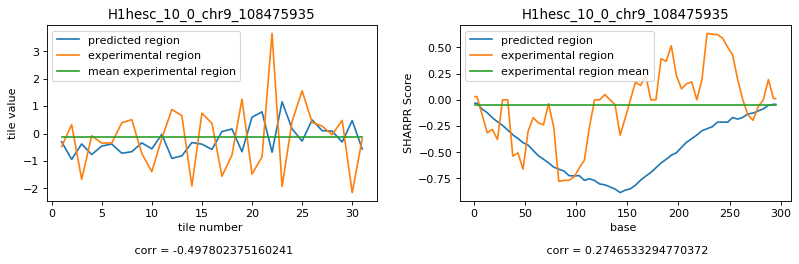

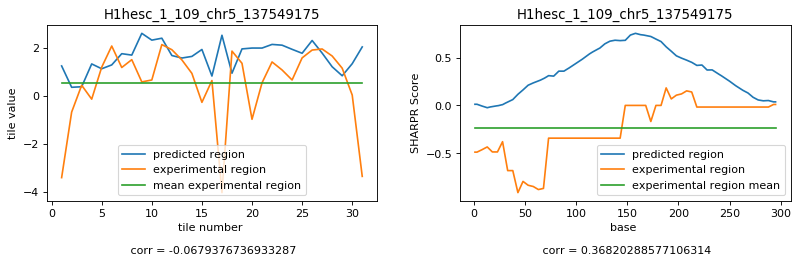

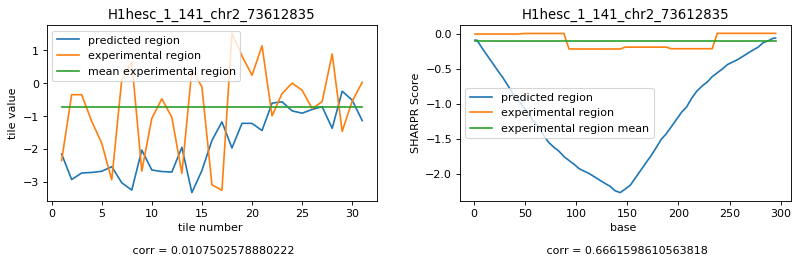

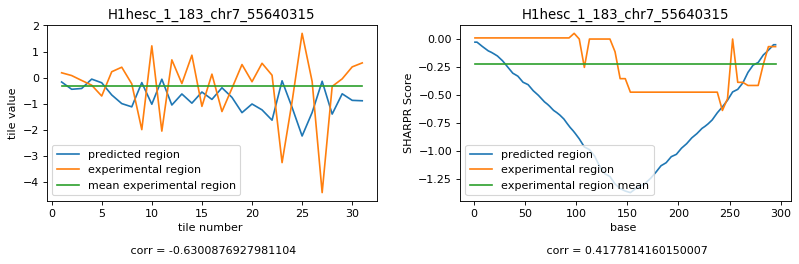

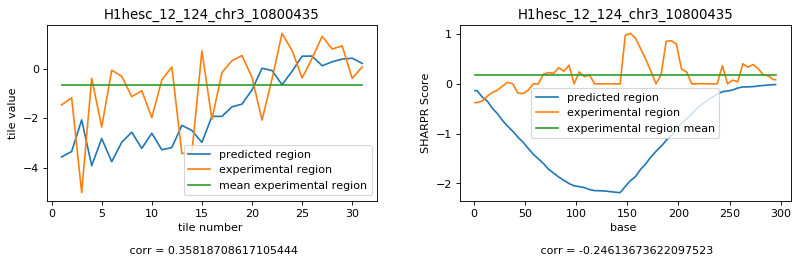

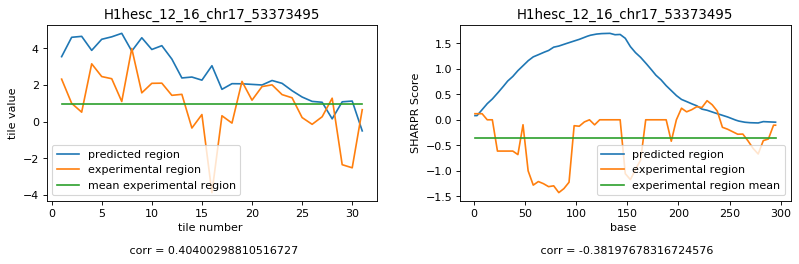

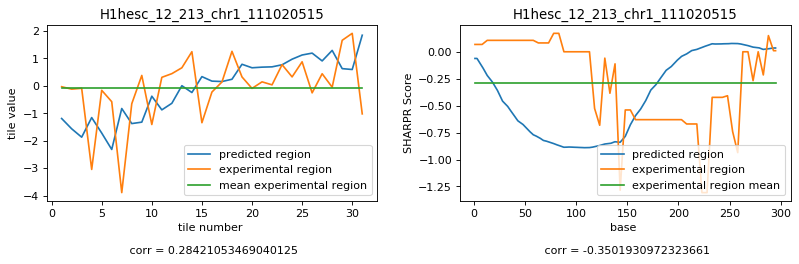

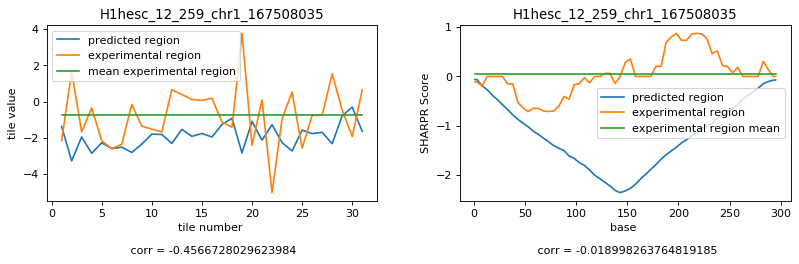

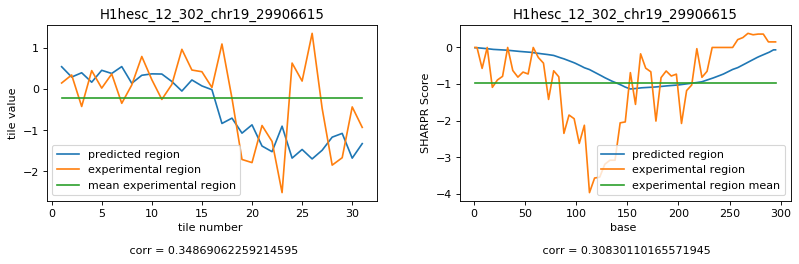

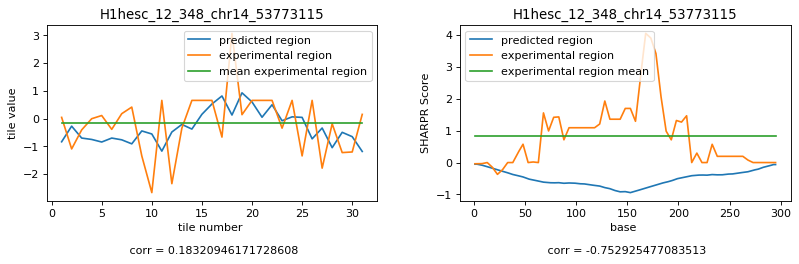

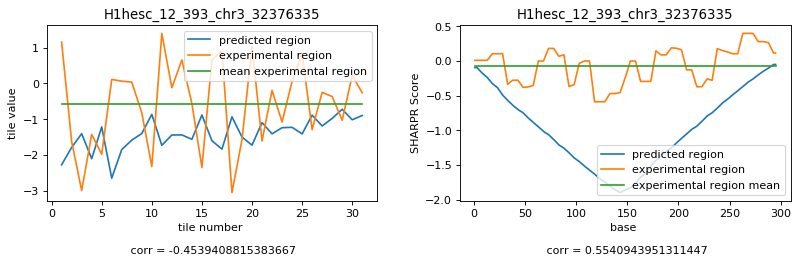

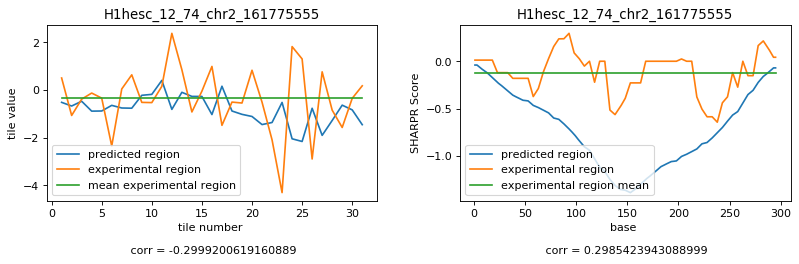

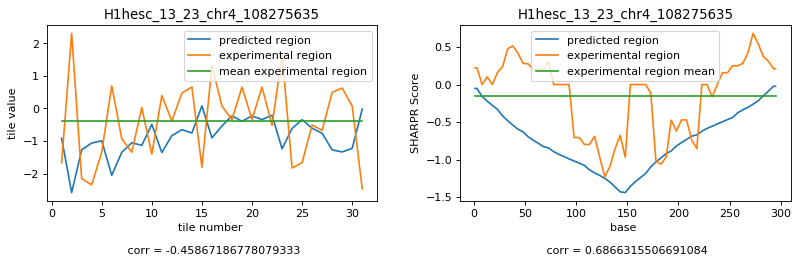

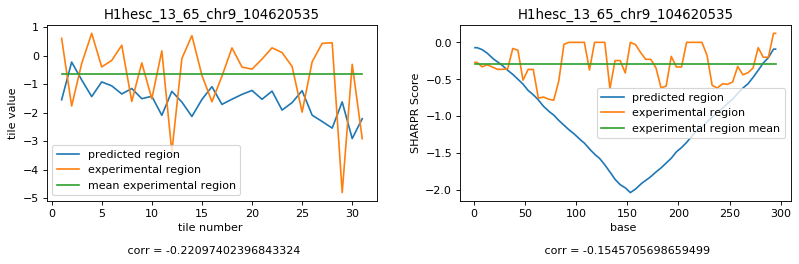

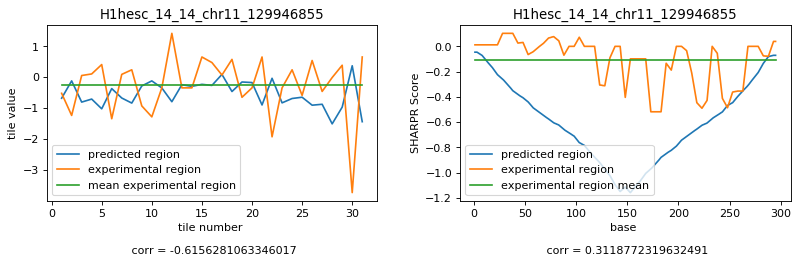

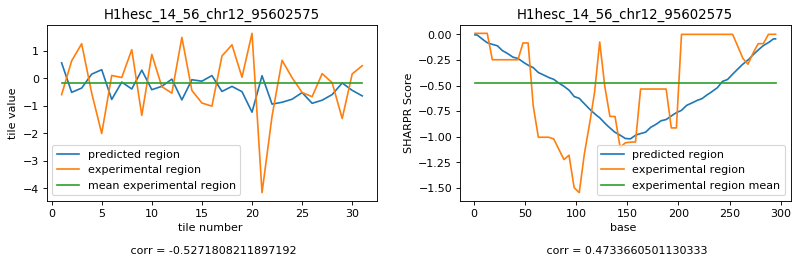

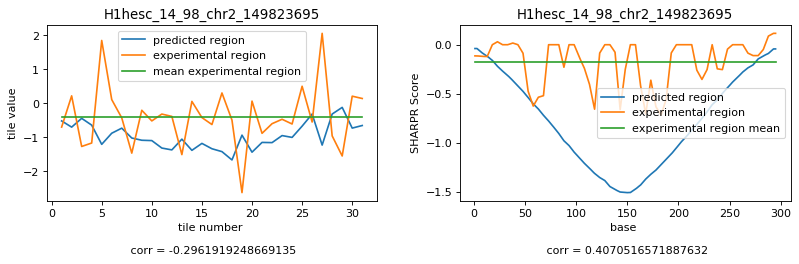

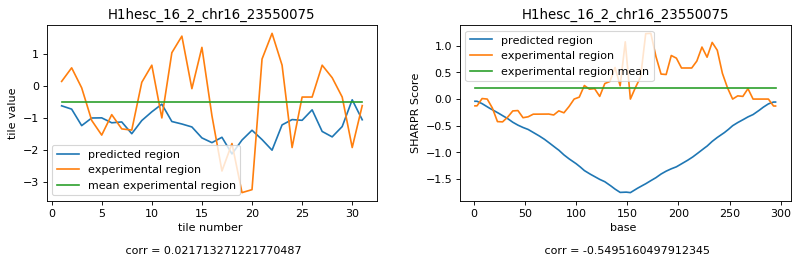

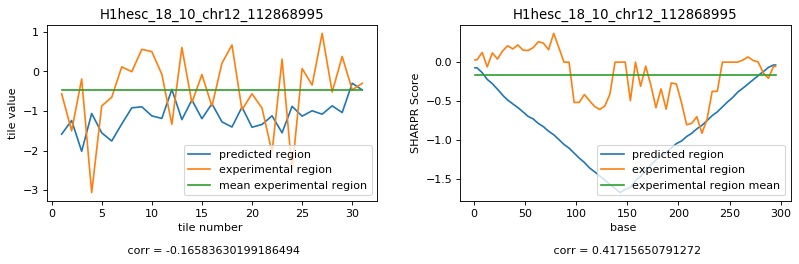

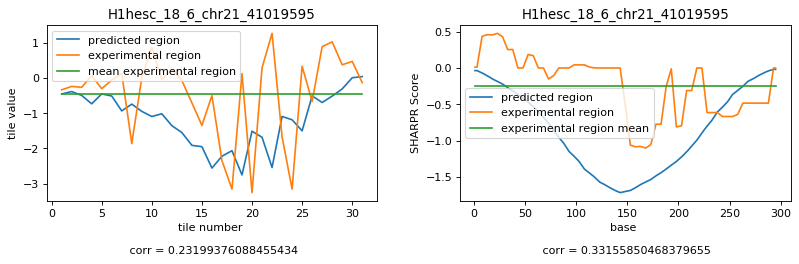

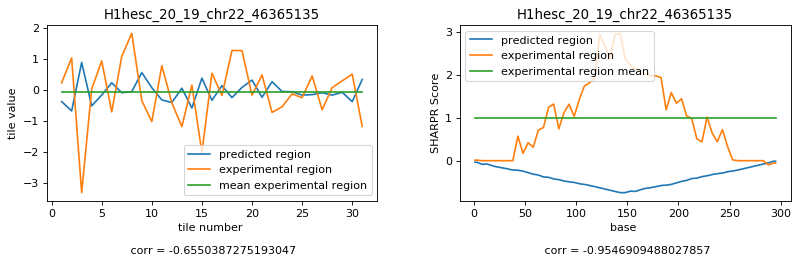

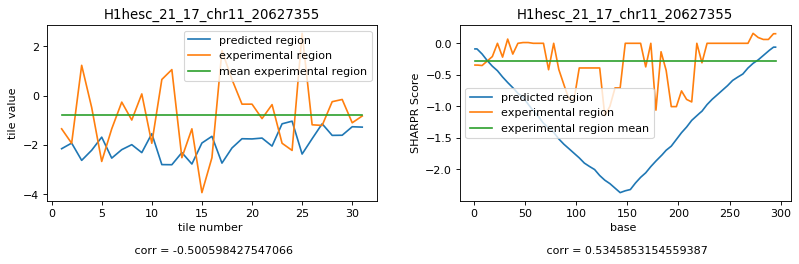

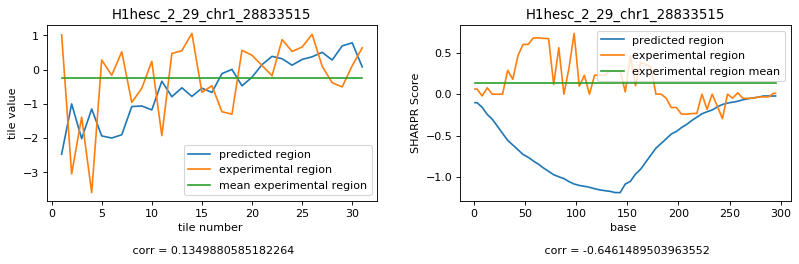

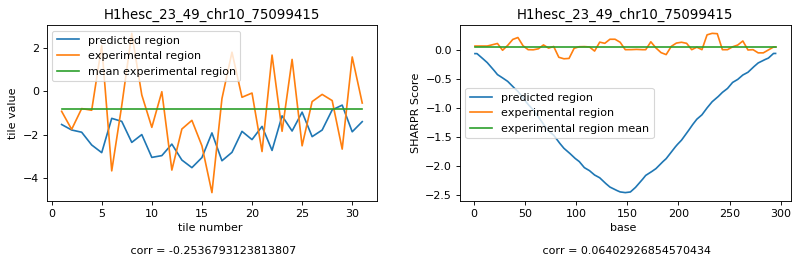

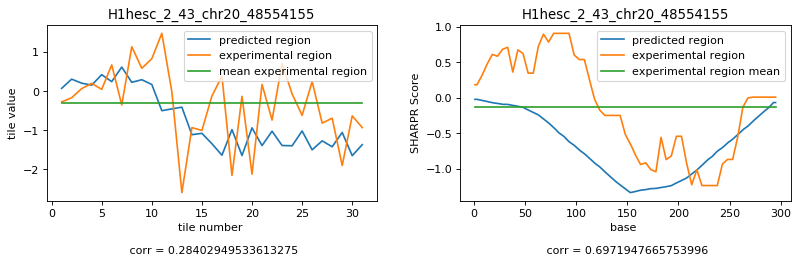

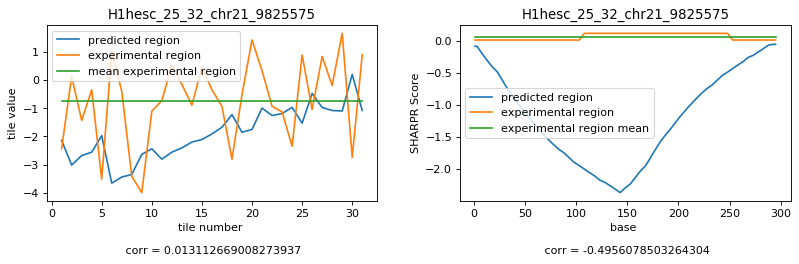

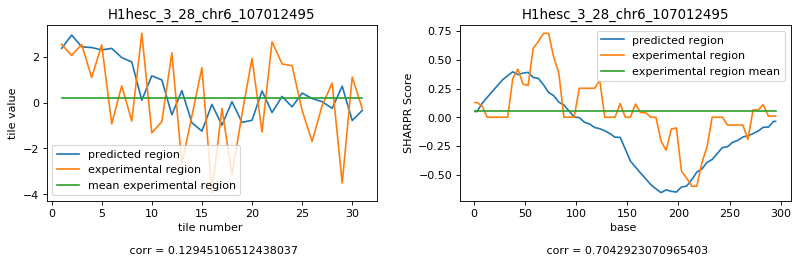

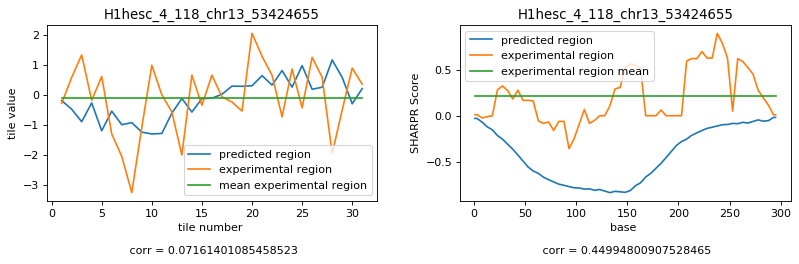

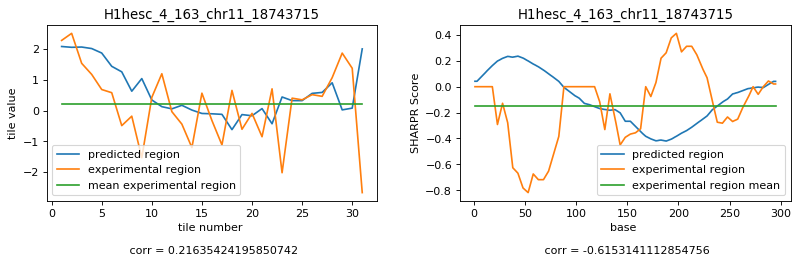

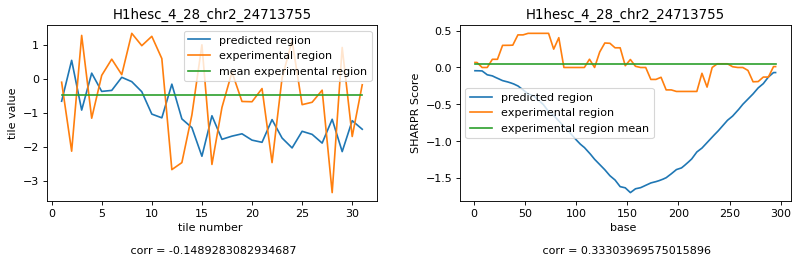

In [52]:
#tile values and SHARPR scores of region side by side
from matplotlib.pyplot import figure
import scipy
from scipy.stats.stats import pearsonr 

for i in indices:
    figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    plt.plot(range(1,32,1), all_predictions.loc[i], label = 'predicted region')
    plt.plot(range(1,32,1), tile_counts.loc[i], label = 'experimental region')
    plt.plot(range(1,32,1), [np.average(tile_counts.loc[i])]*31, label = 'mean experimental region')
    correlation, p = pearsonr(all_predictions.loc[i], tile_counts.loc[i]) 
    plt.xlabel('tile number \n\n corr = %s'%(correlation))
    plt.ylabel('tile value')
    plt.title(i)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(1,296,1), SHARPR_Scores.loc[i], label = 'predicted region')
    plt.plot(range(1,296,1), SHARPR_Paper.loc[i], label = 'experimental region')
    plt.plot(range(1,296,1), [np.average(SHARPR_Paper.loc[i])]*295, label = 'experimental region mean')
    correlation, p = pearsonr(SHARPR_Scores.loc[i], SHARPR_Paper.loc[i]) 
    plt.ylabel('SHARPR Score')
    plt.xlabel('base \n\n corr = %s'%(correlation))
    plt.title(i)
    plt.legend()
    
    plt.subplots_adjust(bottom=0.15, wspace=0.25)
    plt.show()

In [53]:
# predicted = []
# actual = []
# for i in range(0,15720):
#     predicted.append(SHARPR_Scores.iloc[i][145])
#     actual.append(SHARPR_Paper.iloc[i][145])
# plt.scatter(predicted, actual, edgecolor = 'w')    

# correlation, p_val = pearsonr(predicted,actual)
# plt.ylabel('actual base 145 SHARPR Score')
# plt.xlabel('predicted base 145 SHARPR Score \n\n correlation = %s'%(correlation))
# plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

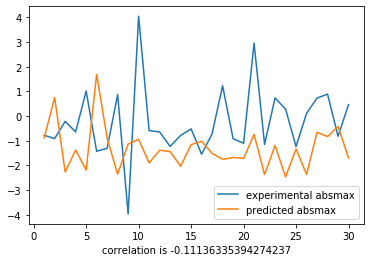

In [85]:
#correlation by region of absmax values of each region
maxCol=lambda x: max(x.min(), x.max(), key=abs)

SHARPR_Scores = SHARPR_Scores.reindex(SHARPR_Paper.index)

absmax_experimental = SHARPR_Paper.apply(maxCol,axis=1)
absmax_predicted = SHARPR_Scores.apply(maxCol,axis=1)

absmax_experimental = absmax_experimental.loc[indices]
absmax_predicted = absmax_predicted.loc[indices]

absmax_experimental.index = range(1, 30+1)
absmax_predicted.index = range(1, 30+1)

plt.plot(absmax_experimental, label = 'experimental absmax')
plt.plot(absmax_predicted, label = 'predicted absmax')
correlation, p = pearsonr(absmax_experimental, absmax_predicted) 
plt.legend()
plt.xlabel('correlation is %s'%correlation)
plt.show